# Introduction

Notebook to analyze the **False Positive** Results for each model in the context of traceability between **test cases** and **bug reports**.

# Load Libraries and Datasets

In [9]:
from mod_finder_util import mod_finder_util
mod_finder_util.add_modules_origin_search_path()

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn3

from modules.models_runner.tc_br_models_runner import TC_BR_Runner
from modules.utils import model_evaluator as m_eval
from modules.utils import aux_functions
from modules.utils import firefox_dataset_p2 as fd
from modules.utils import similarity_measures as sm
from modules.utils import tokenizers as tok

import warnings; warnings.simplefilter('ignore')

# Run All Models

## Volunteers Only Strategy

In [2]:
models_runner_4 = TC_BR_Runner()

lsi_model_4 = models_runner_4.run_lsi_model()
lda_model_4 = models_runner_4.run_lda_model()
bm25_model_4 = models_runner_4.run_bm25_model()
w2v_model_4 = models_runner_4.run_word2vec_model()

oracle=fd.Tc_BR_Oracles.read_oracle_volunteers_df()

evaluator_4 = m_eval.ModelEvaluator(oracle)
evals_df_4 = evaluator_4.run_evaluator(models=[lsi_model_4,lda_model_4,bm25_model_4,w2v_model_4],
                                       top_values=[1,3,5,10], 
                                       sim_thresholds=[(sm.SimilarityMeasure.COSINE, x/10) for x in range(0,10)])

TestCases.shape: (195, 12)
SelectedBugReports.shape: (91, 18)
Running LSI Model ------
Running LDA Model -----
Running BM25 Model -----
Running W2V Model ------
OracleVolunteers.shape: (195, 91)
Evaluating LSI Model ----- 
Evaluating LDA Model ----- 
Evaluating BM25 Model ----- 
Evaluating WORDVECTOR Model ----- 


### Load Datasets

In [10]:
bugreports = fd.Datasets.read_selected_bugreports_df()
testcases = fd.Datasets.read_testcases_df()

SelectedBugReports.shape: (91, 18)
TestCases.shape: (195, 12)


### Tokenization

In [11]:
tokenizer = tok.PorterStemmerBased_Tokenizer()
bugreports['tokens'] = bugreports.apply(lambda row : tokenizer.__call__(row['br_desc']), axis=1)
testcases['tokens'] = testcases.apply(lambda row : tokenizer.__call__(row['tc_desc']), axis=1)

### Results

In [3]:
evals_df_4.head()

,model,ref_name,perc_precision,perc_recall,perc_fscore,eval_df,sim_threshold,top,trace_links_df
0,lsi,top_1_cosine_0.0,30.77,1.93,3.57,precision recall fscore ...,0.0,1.0,br_name BR_1248267_SRC BR_1248268_SRC BR...
1,lsi,top_1_cosine_0.1,30.77,1.93,3.57,precision recall fscore ...,0.1,1.0,br_name BR_1248267_SRC BR_1248268_SRC BR...
2,lsi,top_1_cosine_0.2,30.77,1.93,3.57,precision recall fscore ...,0.2,1.0,br_name BR_1248267_SRC BR_1248268_SRC BR...
3,lsi,top_1_cosine_0.3,30.77,1.93,3.57,precision recall fscore ...,0.3,1.0,br_name BR_1248267_SRC BR_1248268_SRC BR...
4,lsi,top_1_cosine_0.4,28.57,1.86,3.44,precision recall fscore ...,0.4,1.0,br_name BR_1248267_SRC BR_1248268_SRC BR...


### Grouping Results by Model

### Min Precision

model
bm25          21.21
lda            3.30
lsi            0.00
wordvector     4.98
Name: perc_precision, dtype: float64



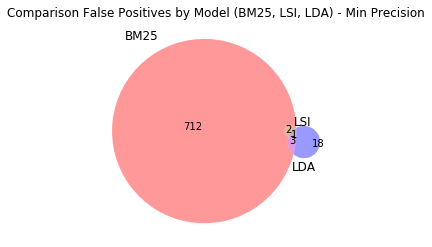

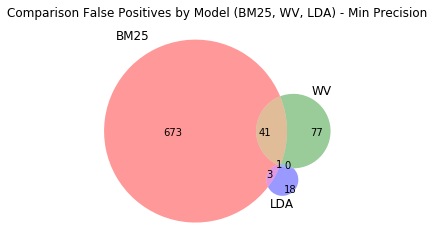

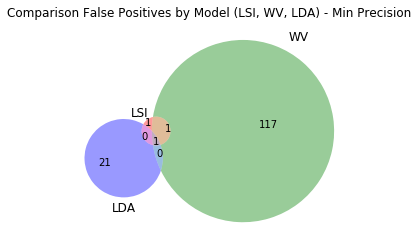

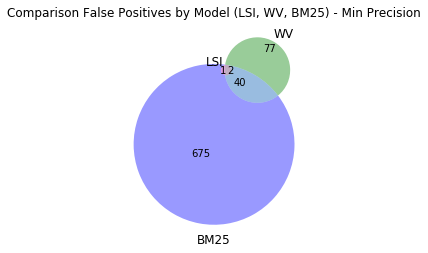

In [4]:
group = evals_df_4.groupby('model').perc_precision.min()
print(group)
print()

bm25_min_prec = group[group.index == 'bm25'].values[0]
lsi_min_prec = group[group.index == 'lsi'].values[0]
lda_min_prec = group[group.index == 'lda'].values[0]
wv_min_prec = group[group.index == 'wordvector'].values[0]

bm25_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='bm25', perc_precision=bm25_min_prec))
lsi_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lsi', perc_precision=lsi_min_prec))
lda_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lda', perc_precision=lda_min_prec))
wv_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='wordvector', perc_precision=wv_min_prec))

venn3([bm25_fp_set, lsi_fp_set, lda_fp_set], ['BM25','LSI','LDA'])
plt.title('Comparison False Positives by Model (BM25, LSI, LDA) - Min Precision')
plt.show()

venn3([bm25_fp_set, wv_fp_set, lda_fp_set], ['BM25','WV','LDA'])
plt.title('Comparison False Positives by Model (BM25, WV, LDA) - Min Precision')
plt.show()

venn3([lsi_fp_set, wv_fp_set, lda_fp_set], ['LSI','WV','LDA'])
plt.title('Comparison False Positives by Model (LSI, WV, LDA) - Min Precision')
plt.show()

venn3([lsi_fp_set, wv_fp_set, bm25_fp_set], ['LSI','WV','BM25'])
plt.title('Comparison False Positives by Model (LSI, WV, BM25) - Min Precision')
plt.show()

##### Exclusive Cases

In [13]:
print("BM25 Exclusive FP:")
bm25_exc_set = bm25_fp_set - lsi_fp_set - lda_fp_set - wv_fp_set
#display(bm25_exc_set)
print("len(bm25_exc_set): {}".format(len(bm25_exc_set)))

print("\n\nLSI Exclusive FP:")
lsi_exc_set = lsi_fp_set - bm25_fp_set - lda_fp_set - wv_fp_set
#display(lsi_exc_set)
print("len(lsi_exc_set): {}".format(len(lsi_exc_set)))

print("\n\nLDA Exclusive FP:")
lda_exc_set = lda_fp_set - lsi_fp_set - bm25_fp_set - wv_fp_set
#display(lda_exc_set)
print("len(lda_exc_set): {}".format(len(lda_exc_set)))

print("\n\nWV Exclusive FP:")
wv_exc_set = wv_fp_set - lda_fp_set - lsi_fp_set - bm25_fp_set
#display(wv_exc_set)
print("len(wv_exc_set): {}".format(len(wv_exc_set)))

BM25 Exclusive FP:
len(bm25_exc_set): 672


LSI Exclusive FP:
len(lsi_exc_set): 0


LDA Exclusive FP:
len(lda_exc_set): 18


WV Exclusive FP:
len(wv_exc_set): 77


##### Word Clouds

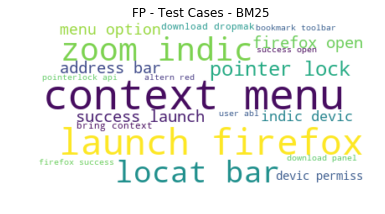

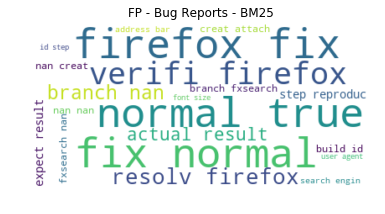

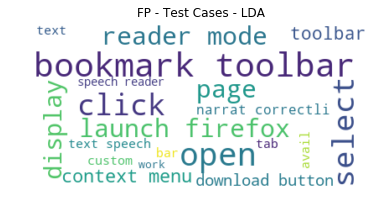

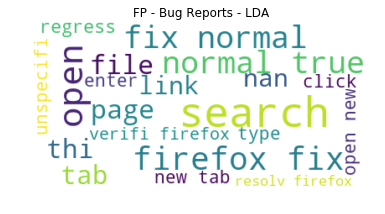

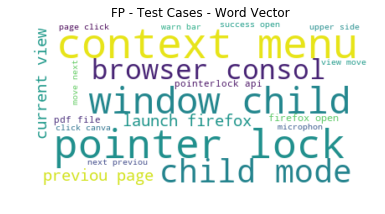

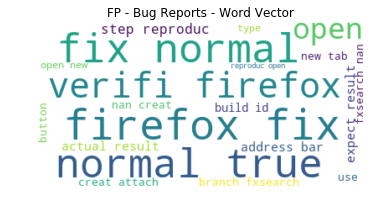

In [14]:
aux_functions.create_wordcloud_tc_br(bm25_exc_set, bugreports=bugreports, testcases=testcases,
                                     wc_tc_title="FP - Test Cases - BM25",
                                     wc_br_title="FP - Bug Reports - BM25")

#aux_functions.create_wordcloud_tc_br(lsi_exc_set, bugreports=bugreports, testcases=testcases,
#                                     wc_tc_title="FP - Test Cases - LSI",
#                                    wc_br_title="FP - Bug Reports - LSI")

aux_functions.create_wordcloud_tc_br(lda_exc_set, bugreports=bugreports, testcases=testcases,
                                     wc_tc_title="FP - Test Cases - LDA",
                                     wc_br_title="FP - Bug Reports - LDA")

aux_functions.create_wordcloud_tc_br(wv_exc_set, bugreports=bugreports, testcases=testcases,
                                     wc_tc_title="FP - Test Cases - Word Vector",
                                     wc_br_title="FP - Bug Reports - Word Vector")

##### False Positives Amount by Model

In [15]:
print("LSI FP Amount: {}".format(len(lsi_fp_set)))
print("LDA FP Amount: {}".format(len(lda_fp_set)))
print("BM25 FP Amount: {}".format(len(bm25_fp_set)))
print("WV FP Amount: {}".format(len(wv_fp_set)))

LSI FP Amount: 3
LDA FP Amount: 22
BM25 FP Amount: 718
WV FP Amount: 119


##### Detailing Features for Exclusive Sets

In [18]:
aux_functions.detail_features_tc_br(bm25_exc_set, bugreports=bugreports, testcases=testcases)
aux_functions.detail_features_tc_br(lda_exc_set, bugreports=bugreports, testcases=testcases)
aux_functions.detail_features_tc_br(lsi_exc_set, bugreports=bugreports, testcases=testcases)
aux_functions.detail_features_tc_br(wv_exc_set, bugreports=bugreports, testcases=testcases)

,tc,tc_feat,br,br_summary
0,TC_36_TRG,Windows Child Mode,BR_1318903_SRC,"[Windows 7 and below] Fullscreen window controls not shown with dark themes, close button has broken ""red square"" hover state"
1,TC_88_TRG,Context Menu,BR_1330745_SRC,"When privacy.userContext.longPressBehavior is set to 1, it's impossible to open a default container tab from the + button."
2,TC_129_TRG,Pointer Lock API,BR_1301784_SRC,Pref-off Search Reset UI for 50 beta
3,TC_18_TRG,New Awesome Bar,BR_1312018_SRC,Keyword search is always performed in lowercase
4,TC_15_TRG,New Awesome Bar,BR_1299458_SRC,Telemetry data from Search bar is not properly collected when searching in new tab from context menu
5,TC_28_TRG,Windows Child Mode,BR_1357085_SRC,Confirm your account pref screen should no longer redirect to Sync prefs
6,TC_186_TRG,Indicator for device permissions,BR_1297374_SRC,"[One-off searches] When changing the default search engine from Awesomebar, the icon of the new default engine is replaced by the icon of the old default engine"
7,TC_15_TRG,New Awesome Bar,BR_1314643_SRC,[One-off searches] Changing the default search engine from Search bar does not work first time
8,TC_28_TRG,Windows Child Mode,BR_1302468_SRC,Firefox Beta reports channel as 'release' when build is RC due to use of Services.appinfo.defaultUpdateChannel
9,TC_155_TRG,Downloads Dropmaker,BR_1353831_SRC,OneOff block in search bar doesn't update text if Customize was opened at least once


,tc,tc_feat,br,br_summary
0,TC_155_TRG,Downloads Dropmaker,BR_1301056_SRC,"[e10s] Link with target=""_blank"" to download a file leaves a about:blank window/tab open after the download"
1,TC_165_TRG,Downloads Dropmaker,BR_1287823_SRC,[Linux] Dragging & dropping a download from the downloads panel on desktop saves a txt file
2,TC_63_TRG,Browser Customization,BR_1330745_SRC,"When privacy.userContext.longPressBehavior is set to 1, it's impossible to open a default container tab from the + button."
3,TC_143_TRG,Zoom Indicator,BR_1337682_SRC,using ctrl / shift + enter seems to save the URL to a hidden clipboard that populates when hitting enter (hard to describe).
4,TC_118_TRG,Text to Speech in Reader Mode,BR_1294887_SRC,Middle clicking search results does not open a new tab
5,TC_119_TRG,Text to Speech in Reader Mode,BR_1451475_SRC,Renew scalar browser.engagement.restored_pinned_tabs_count
6,TC_14_TRG,New Awesome Bar,BR_1267480_SRC,Intermittent browser/components/preferences/in-content/tests/browser_security.jsThis test exceeded the timeout threshold. It should be rewritten or split up.
7,TC_63_TRG,Browser Customization,BR_1295502_SRC,"2.1 - 4.09% tart / tresize / tsvgx (linux64, windows7-32, windows8-64) regression on push 6af49d08884d76de44efd9387bbe340921652364 (Fri Aug 12 2016)"
8,TC_155_TRG,Downloads Dropmaker,BR_1309856_SRC,Fix bookmarks twisty direction in RTL locales on Mac OS X
9,TC_88_TRG,Context Menu,BR_1296366_SRC,"Ctrl+Click awesomebar entry with ""Switch to Tab"" doesn't open new tab"


,tc,tc_feat,br,br_summary


,tc,tc_feat,br,br_summary
0,TC_79_TRG,Context Menu,BR_1289832_SRC,Open Link in New *Current Container* missing from context menu when opening about:newtab thumbnails
1,TC_29_TRG,Windows Child Mode,BR_1299458_SRC,Telemetry data from Search bar is not properly collected when searching in new tab from context menu
2,TC_29_TRG,Windows Child Mode,BR_1345687_SRC,[Regression] Clicking on audioVideoButton / sharing-icon don't work when typed on urlbar
3,TC_130_TRG,Pointer Lock API,BR_1353831_SRC,OneOff block in search bar doesn't update text if Customize was opened at least once
4,TC_117_TRG,Text to Speech in Reader Mode,BR_1297976_SRC,[One-off searches] Screen reader does not read the one-offs searches buttons
5,TC_128_TRG,Pointer Lock API,BR_1296322_SRC,X button is vertically misaligned on the permission dropdown
6,TC_47_TRG,APZ - Async Scrolling,BR_1344446_SRC,tab bar scroll buttons are too narrow for touchscreen use
7,TC_130_TRG,Pointer Lock API,BR_1365887_SRC,Can't open resource:///modules/ from the location bar
8,TC_79_TRG,Context Menu,BR_1296366_SRC,"Ctrl+Click awesomebar entry with ""Switch to Tab"" doesn't open new tab"
9,TC_81_TRG,Context Menu,BR_1330745_SRC,"When privacy.userContext.longPressBehavior is set to 1, it's impossible to open a default container tab from the + button."


#### Max Precision

model
bm25          28.57
lda           14.62
lsi           30.77
wordvector    15.38
Name: perc_precision, dtype: float64



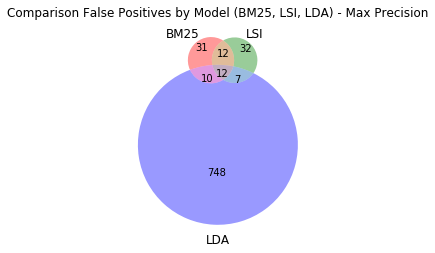

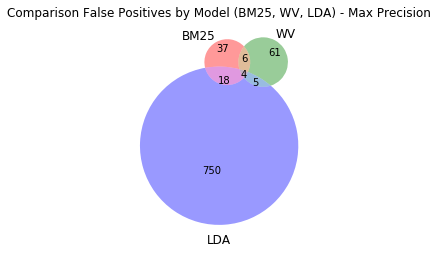

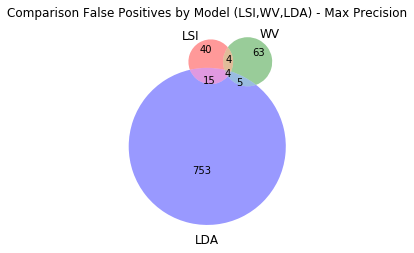

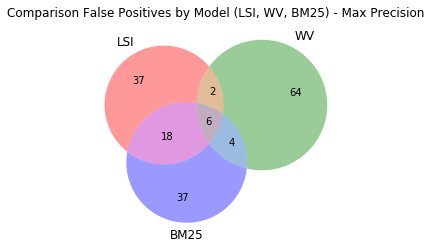

In [19]:
group = evals_df_4.groupby('model').perc_precision.max()
print(group)
print()

bm25_max_prec = group[group.index == 'bm25'].values[0]
lsi_max_prec = group[group.index == 'lsi'].values[0]
lda_max_prec = group[group.index == 'lda'].values[0]
wv_max_prec = group[group.index == 'wordvector'].values[0]

bm25_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='bm25', perc_precision=bm25_max_prec))
lsi_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lsi', perc_precision=lsi_max_prec))
lda_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lda', perc_precision=lda_max_prec))
wv_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='wordvector', perc_precision=wv_max_prec))

venn3([bm25_fp_set, lsi_fp_set, lda_fp_set], ['BM25','LSI','LDA'])
plt.title('Comparison False Positives by Model (BM25, LSI, LDA) - Max Precision')
plt.show()

venn3([bm25_fp_set, wv_fp_set, lda_fp_set], ['BM25','WV','LDA'])
plt.title('Comparison False Positives by Model (BM25, WV, LDA) - Max Precision')
plt.show()

venn3([lsi_fp_set, wv_fp_set, lda_fp_set], ['LSI','WV','LDA'])
plt.title('Comparison False Positives by Model (LSI,WV,LDA) - Max Precision')
plt.show()

venn3([lsi_fp_set, wv_fp_set, bm25_fp_set], ['LSI','WV','BM25'])
plt.title('Comparison False Positives by Model (LSI, WV, BM25) - Max Precision')
plt.show()

##### Exclusive Cases

In [20]:
print("BM25 Exclusive FP:")
bm25_exc_set = bm25_fp_set - lsi_fp_set - lda_fp_set - wv_fp_set
#display(bm25_exc_set)
print("len(bm25_exc_set): {}".format(len(bm25_exc_set)))

print("\n\nLSI Exclusive FP:")
lsi_exc_set = lsi_fp_set - bm25_fp_set - lda_fp_set - wv_fp_set
#display(lsi_exc_set)
print("len(lsi_exc_set): {}".format(len(lsi_exc_set)))

print("\n\nLDA Exclusive FP:")
lda_exc_set = lda_fp_set - lsi_fp_set - bm25_fp_set - wv_fp_set
#display(lda_exc_set)
print("len(lda_exc_set): {}".format(len(lda_exc_set)))

print("\n\nWV Exclusive FP:")
wv_exc_set = wv_fp_set - lda_fp_set - lsi_fp_set - bm25_fp_set
#display(wv_exc_set)
print("len(wv_exc_set): {}".format(len(wv_exc_set)))

BM25 Exclusive FP:
len(bm25_exc_set): 28


LSI Exclusive FP:
len(lsi_exc_set): 31


LDA Exclusive FP:
len(lda_exc_set): 744


WV Exclusive FP:
len(wv_exc_set): 60


##### Word Clouds

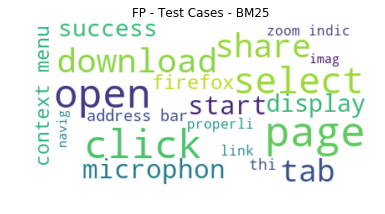

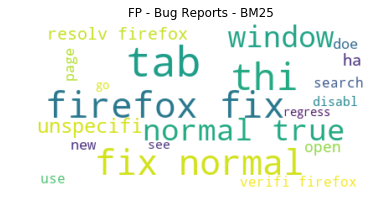

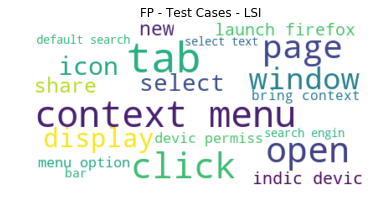

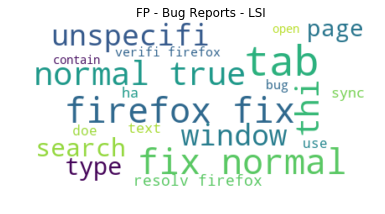

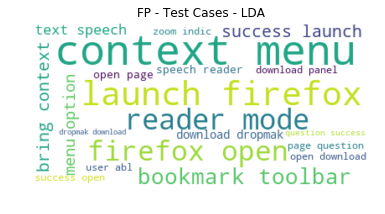

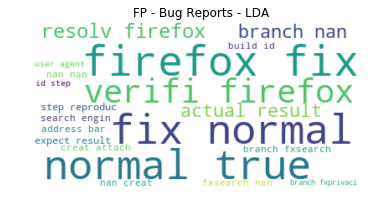

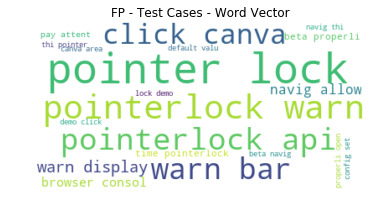

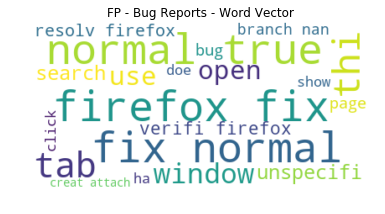

In [24]:
aux_functions.create_wordcloud_tc_br(bm25_exc_set, bugreports=bugreports, testcases=testcases,
                                     wc_tc_title="FP - Test Cases - BM25",
                                     wc_br_title="FP - Bug Reports - BM25")

aux_functions.create_wordcloud_tc_br(lsi_exc_set, bugreports=bugreports, testcases=testcases,
                                     wc_tc_title="FP - Test Cases - LSI",
                                    wc_br_title="FP - Bug Reports - LSI")

aux_functions.create_wordcloud_tc_br(lda_exc_set, bugreports=bugreports, testcases=testcases,
                                     wc_tc_title="FP - Test Cases - LDA",
                                     wc_br_title="FP - Bug Reports - LDA")

aux_functions.create_wordcloud_tc_br(wv_exc_set, bugreports=bugreports, testcases=testcases,
                                     wc_tc_title="FP - Test Cases - Word Vector",
                                     wc_br_title="FP - Bug Reports - Word Vector")

##### False Positives Amount by Model

In [22]:
print("LSI FP Amount: {}".format(len(lsi_fp_set)))
print("LDA FP Amount: {}".format(len(lda_fp_set)))
print("BM25 FP Amount: {}".format(len(bm25_fp_set)))
print("WV FP Amount: {}".format(len(wv_fp_set)))

LSI FP Amount: 63
LDA FP Amount: 777
BM25 FP Amount: 65
WV FP Amount: 76


##### Detailing Features for Exclusive Sets

In [23]:
aux_functions.detail_features_tc_br(bm25_exc_set, bugreports=bugreports, testcases=testcases)
aux_functions.detail_features_tc_br(lda_exc_set, bugreports=bugreports, testcases=testcases)
aux_functions.detail_features_tc_br(lsi_exc_set, bugreports=bugreports, testcases=testcases)
aux_functions.detail_features_tc_br(wv_exc_set, bugreports=bugreports, testcases=testcases)

,tc,tc_feat,br,br_summary
0,TC_18_TRG,New Awesome Bar,BR_1269485_SRC,"New Private Browsing start-page has white/gray-text-on-white-background, in overflowed area off the right side of the window"
1,TC_72_TRG,PDF Viewer,BR_1305676_SRC,In some circumstances passive mixed content indicator will override active mixed content indicator
2,TC_73_TRG,Context Menu,BR_1325902_SRC,Increase visibility of container highlight on tabs
3,TC_166_TRG,Downloads Dropmaker,BR_1295502_SRC,"2.1 - 4.09% tart / tresize / tsvgx (linux64, windows7-32, windows8-64) regression on push 6af49d08884d76de44efd9387bbe340921652364 (Fri Aug 12 2016)"
4,TC_128_TRG,Pointer Lock API,BR_1313969_SRC,"[Follow-up] Ctrl+Click awesomebar entry with ""Switch to Tab"" doesn't open new tab"
5,TC_127_TRG,Pointer Lock API,BR_1276120_SRC,Autocomplete suggestions just don't go away after Win+Down
6,TC_135_TRG,Pointer Lock API,BR_1267501_SRC,New Private Browsing start-page overflows off the *left side of the window* (making content unscrollable) for small window sizes
7,TC_193_TRG,Indicator for device permissions,BR_1303339_SRC,The animated sharing icons of the control center panel never go to full opacity
8,TC_27_TRG,Windows Child Mode,BR_1328913_SRC,Pref-off Search Reset UI for beta and release
9,TC_183_TRG,Indicator for device permissions,BR_1449700_SRC,refactor addTab/moveTabTo


,tc,tc_feat,br,br_summary
0,TC_172_TRG,WebGL2,BR_1269348_SRC,Show last sync date tooltip on Synced Tabs sidebar device names
1,TC_18_TRG,New Awesome Bar,BR_1312018_SRC,Keyword search is always performed in lowercase
2,TC_155_TRG,Downloads Dropmaker,BR_1269348_SRC,Show last sync date tooltip on Synced Tabs sidebar device names
3,TC_75_TRG,Context Menu,BR_1279143_SRC,"color indicator missing when ""File -> New Container Tab"" without any windows opened"
4,TC_83_TRG,Context Menu,BR_1296322_SRC,X button is vertically misaligned on the permission dropdown
5,TC_156_TRG,Downloads Dropmaker,BR_1319433_SRC,Devices differ in Synced Tab and Send to Device menus
6,TC_164_TRG,Downloads Dropmaker,BR_1282759_SRC,Support whole word search for find in page
7,TC_13_TRG,New Awesome Bar,BR_1269485_SRC,"New Private Browsing start-page has white/gray-text-on-white-background, in overflowed area off the right side of the window"
8,TC_174_TRG,FLAC support,BR_1270983_SRC,Intermittent browser_contextmenu.jsTest timed outFound a tab after previous test timed out: subtst_contextmenu.html -
9,TC_84_TRG,Context Menu,BR_1430603_SRC,Restrict BROWSER_*_DEFAULT probes to parent-process only


,tc,tc_feat,br,br_summary
0,TC_119_TRG,Text to Speech in Reader Mode,BR_1323211_SRC,Change Sync datatype label from Tabs to Open tabs
1,TC_191_TRG,Indicator for device permissions,BR_1316126_SRC,`_endRemoveTab` can get stuck in an infinite loop
2,TC_92_TRG,Context Menu,BR_1267501_SRC,New Private Browsing start-page overflows off the *left side of the window* (making content unscrollable) for small window sizes
3,TC_38_TRG,APZ - Async Scrolling,BR_1277937_SRC,https has an underline instead of a strikethrough when mixed active content is loaded
4,TC_190_TRG,Indicator for device permissions,BR_1281190_SRC,Keep collecting telemetry for Permissions Notifications until version 55
5,TC_105_TRG,Windows 10 Compatibility,BR_1313969_SRC,"[Follow-up] Ctrl+Click awesomebar entry with ""Switch to Tab"" doesn't open new tab"
6,TC_18_TRG,New Awesome Bar,BR_1290424_SRC,"Mouse-over (hover) on a dropdown suggestion (search, URL) causes the hovered-over item to be deleted on 'delete'-press"
7,TC_190_TRG,Indicator for device permissions,BR_1408361_SRC,Received tab is truncated prematurely in notification
8,TC_88_TRG,Context Menu,BR_1279140_SRC,awesomebar displaying incorrect text UI for containers
9,TC_191_TRG,Indicator for device permissions,BR_1449700_SRC,refactor addTab/moveTabTo


,tc,tc_feat,br,br_summary
0,TC_14_TRG,New Awesome Bar,BR_1320557_SRC,"No security information displayed for a specific website, using a specific Firefox profile"
1,TC_130_TRG,Pointer Lock API,BR_1319119_SRC,Turn on Insecure Password Warning in Firefox Release
2,TC_33_TRG,Windows Child Mode,BR_1257087_SRC,Middle mouse click on history item would not open
3,TC_130_TRG,Pointer Lock API,BR_1335538_SRC,Request volume to profile.accounts.firefox.com has doubled starting in Firefox 51
4,TC_29_TRG,Windows Child Mode,BR_1337682_SRC,using ctrl / shift + enter seems to save the URL to a hidden clipboard that populates when hitting enter (hard to describe).
5,TC_135_TRG,Pointer Lock API,BR_1309856_SRC,Fix bookmarks twisty direction in RTL locales on Mac OS X
6,TC_181_TRG,Indicator for device permissions,BR_1319919_SRC,Refine Insecure Password Warning style
7,TC_32_TRG,Windows Child Mode,BR_1432915_SRC,Do not write the kMDItemWhereFroms xattr metadata for files downloaded in Private Browsing mode
8,TC_14_TRG,New Awesome Bar,BR_1312018_SRC,Keyword search is always performed in lowercase
9,TC_29_TRG,Windows Child Mode,BR_1269485_SRC,"New Private Browsing start-page has white/gray-text-on-white-background, in overflowed area off the right side of the window"


#### Min Recall

model
bm25          1.54
lda           0.56
lsi           0.00
wordvector    0.38
Name: perc_recall, dtype: float64



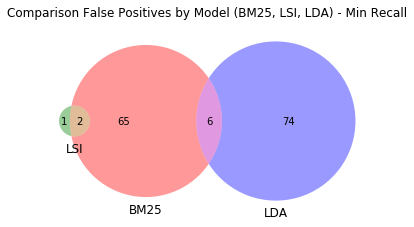

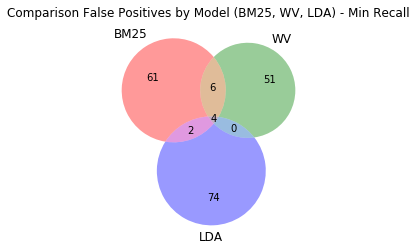

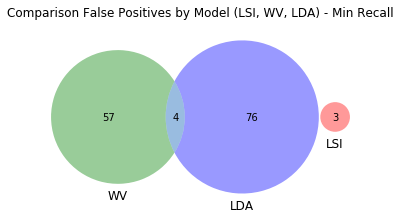

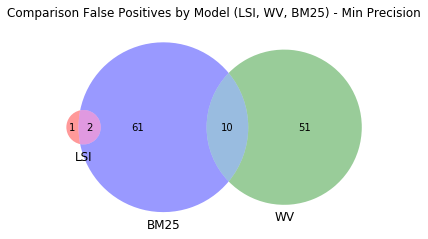

In [7]:
group = evals_df_4.groupby('model').perc_recall.min()
print(group)
print()

bm25_min_recall = group[group.index == 'bm25'].values[0]
lsi_min_recall = group[group.index == 'lsi'].values[0]
lda_min_recall = group[group.index == 'lda'].values[0]
wv_min_recall = group[group.index == 'wordvector'].values[0]

bm25_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='bm25', perc_recall=bm25_min_recall))
lsi_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lsi', perc_recall=lsi_min_recall))
lda_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lda', perc_recall=lda_min_recall))
wv_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='wordvector', perc_recall=wv_min_recall))

venn3([bm25_fp_set, lsi_fp_set, lda_fp_set], ['BM25','LSI','LDA'])
plt.title('Comparison False Positives by Model (BM25, LSI, LDA) - Min Recall')
plt.show()

venn3([bm25_fp_set, wv_fp_set, lda_fp_set], ['BM25','WV','LDA'])
plt.title('Comparison False Positives by Model (BM25, WV, LDA) - Min Recall')
plt.show()

venn3([lsi_fp_set, wv_fp_set, lda_fp_set], ['LSI','WV','LDA'])
plt.title('Comparison False Positives by Model (LSI, WV, LDA) - Min Recall')
plt.show()

venn3([lsi_fp_set, wv_fp_set, bm25_fp_set], ['LSI','WV','BM25'])
plt.title('Comparison False Positives by Model (LSI, WV, BM25) - Min Recall')
plt.show()

##### Exclusive Cases

In [8]:
print("BM25 Exclusive FP:")
display(bm25_fp_set - lsi_fp_set - lda_fp_set - wv_fp_set)

print("\n\nLSI Exclusive FP:")
display(lsi_fp_set - bm25_fp_set - lda_fp_set - wv_fp_set)

print("\n\nLDA Exclusive FP:")
display(lda_fp_set - lsi_fp_set - bm25_fp_set - wv_fp_set)

print("\n\nWV Exclusive FP:")
display(wv_fp_set - lda_fp_set - lsi_fp_set - bm25_fp_set)

BM25 Exclusive FP:


{('TC_100_TRG', 'BR_1301421_SRC'),
 ('TC_107_TRG', 'BR_1328913_SRC'),
 ('TC_109_TRG', 'BR_1271607_SRC'),
 ('TC_115_TRG', 'BR_1319919_SRC'),
 ('TC_121_TRG', 'BR_1313290_SRC'),
 ('TC_121_TRG', 'BR_1319119_SRC'),
 ('TC_121_TRG', 'BR_1339497_SRC'),
 ('TC_122_TRG', 'BR_1302468_SRC'),
 ('TC_127_TRG', 'BR_1276120_SRC'),
 ('TC_135_TRG', 'BR_1267501_SRC'),
 ('TC_135_TRG', 'BR_1269485_SRC'),
 ('TC_137_TRG', 'BR_1283542_SRC'),
 ('TC_137_TRG', 'BR_1336227_SRC'),
 ('TC_137_TRG', 'BR_1451475_SRC'),
 ('TC_142_TRG', 'BR_1287384_SRC'),
 ('TC_146_TRG', 'BR_1270983_SRC'),
 ('TC_149_TRG', 'BR_1281190_SRC'),
 ('TC_14_TRG', 'BR_1282759_SRC'),
 ('TC_160_TRG', 'BR_1264988_SRC'),
 ('TC_162_TRG', 'BR_1267480_SRC'),
 ('TC_162_TRG', 'BR_1278388_SRC'),
 ('TC_162_TRG', 'BR_1305676_SRC'),
 ('TC_162_TRG', 'BR_1305737_SRC'),
 ('TC_163_TRG', 'BR_1285328_SRC'),
 ('TC_163_TRG', 'BR_1290424_SRC'),
 ('TC_163_TRG', 'BR_1365887_SRC'),
 ('TC_174_TRG', 'BR_1297686_SRC'),
 ('TC_175_TRG', 'BR_1285041_SRC'),
 ('TC_17_TRG', 'BR_12



LSI Exclusive FP:


{('TC_61_TRG', 'BR_1287748_SRC')}



LDA Exclusive FP:


{('TC_143_TRG', 'BR_1430603_SRC'),
 ('TC_14_TRG', 'BR_1297686_SRC'),
 ('TC_159_TRG', 'BR_1264988_SRC'),
 ('TC_159_TRG', 'BR_1276120_SRC'),
 ('TC_159_TRG', 'BR_1277937_SRC'),
 ('TC_159_TRG', 'BR_1287823_SRC'),
 ('TC_159_TRG', 'BR_1289240_SRC'),
 ('TC_159_TRG', 'BR_1290424_SRC'),
 ('TC_159_TRG', 'BR_1293308_SRC'),
 ('TC_159_TRG', 'BR_1295502_SRC'),
 ('TC_159_TRG', 'BR_1296322_SRC'),
 ('TC_159_TRG', 'BR_1296861_SRC'),
 ('TC_159_TRG', 'BR_1297976_SRC'),
 ('TC_159_TRG', 'BR_1301056_SRC'),
 ('TC_159_TRG', 'BR_1301421_SRC'),
 ('TC_159_TRG', 'BR_1305195_SRC'),
 ('TC_159_TRG', 'BR_1313778_SRC'),
 ('TC_159_TRG', 'BR_1318903_SRC'),
 ('TC_159_TRG', 'BR_1336227_SRC'),
 ('TC_159_TRG', 'BR_1343256_SRC'),
 ('TC_159_TRG', 'BR_1353831_SRC'),
 ('TC_160_TRG', 'BR_1305737_SRC'),
 ('TC_161_TRG', 'BR_1303339_SRC'),
 ('TC_16_TRG', 'BR_1345687_SRC'),
 ('TC_174_TRG', 'BR_1248267_SRC'),
 ('TC_174_TRG', 'BR_1269485_SRC'),
 ('TC_176_TRG', 'BR_1432915_SRC'),
 ('TC_17_TRG', 'BR_1319919_SRC'),
 ('TC_17_TRG', 'BR_1335



WV Exclusive FP:


{('TC_100_TRG', 'BR_1292566_SRC'),
 ('TC_107_TRG', 'BR_1271607_SRC'),
 ('TC_128_TRG', 'BR_1292573_SRC'),
 ('TC_128_TRG', 'BR_1323211_SRC'),
 ('TC_128_TRG', 'BR_1344446_SRC'),
 ('TC_130_TRG', 'BR_1279864_SRC'),
 ('TC_130_TRG', 'BR_1281493_SRC'),
 ('TC_130_TRG', 'BR_1301421_SRC'),
 ('TC_130_TRG', 'BR_1319433_SRC'),
 ('TC_130_TRG', 'BR_1336227_SRC'),
 ('TC_131_TRG', 'BR_1302468_SRC'),
 ('TC_132_TRG', 'BR_1264988_SRC'),
 ('TC_132_TRG', 'BR_1287384_SRC'),
 ('TC_132_TRG', 'BR_1287748_SRC'),
 ('TC_135_TRG', 'BR_1289240_SRC'),
 ('TC_135_TRG', 'BR_1297686_SRC'),
 ('TC_135_TRG', 'BR_1311998_SRC'),
 ('TC_135_TRG', 'BR_1318903_SRC'),
 ('TC_135_TRG', 'BR_1319119_SRC'),
 ('TC_135_TRG', 'BR_1330745_SRC'),
 ('TC_135_TRG', 'BR_1334844_SRC'),
 ('TC_135_TRG', 'BR_1365887_SRC'),
 ('TC_136_TRG', 'BR_1282759_SRC'),
 ('TC_137_TRG', 'BR_1320557_SRC'),
 ('TC_152_TRG', 'BR_1297336_SRC'),
 ('TC_175_TRG', 'BR_1313969_SRC'),
 ('TC_175_TRG', 'BR_1339497_SRC'),
 ('TC_27_TRG', 'BR_1313778_SRC'),
 ('TC_32_TRG', 'BR_12

#### Max Recall

model
bm25           9.54
lda            5.55
lsi           14.42
wordvector     3.22
Name: perc_recall, dtype: float64



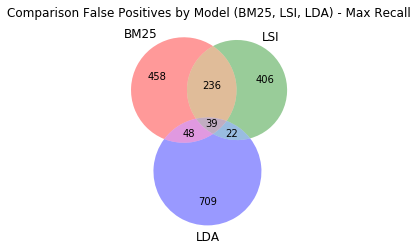

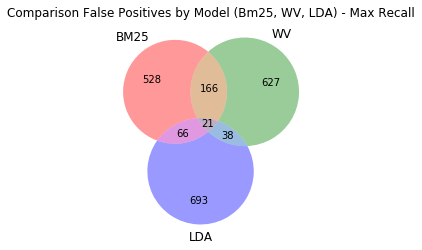

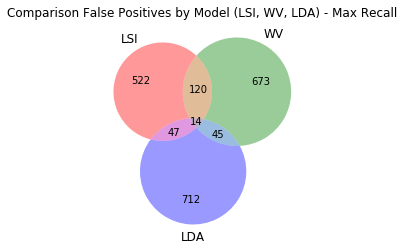

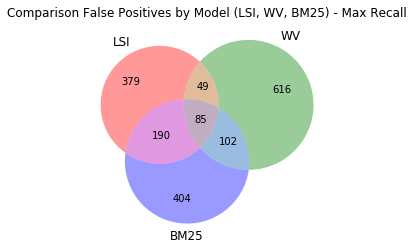

In [13]:
group = evals_df_4.groupby('model').perc_recall.max()
print(group)
print()

bm25_max_recall = group[group.index == 'bm25'].values[0]
lsi_max_recall = group[group.index == 'lsi'].values[0]
lda_max_recall = group[group.index == 'lda'].values[0]
wv_max_recall = group[group.index == 'wordvector'].values[0]

bm25_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='bm25', perc_recall=bm25_max_recall))
lsi_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lsi', perc_recall=lsi_max_recall))
lda_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='lda', perc_recall=lda_max_recall))
wv_fp_set = aux_functions.get_false_positives(oracle, aux_functions.get_trace_links_df(evaluations_df=evals_df_4, model='wordvector', perc_recall=wv_max_recall))

venn3([bm25_fp_set, lsi_fp_set, lda_fp_set], ['BM25','LSI','LDA'])
plt.title('Comparison False Positives by Model (BM25, LSI, LDA) - Max Recall')
plt.show()

venn3([bm25_fp_set, wv_fp_set, lda_fp_set], ['BM25','WV','LDA'])
plt.title('Comparison False Positives by Model (Bm25, WV, LDA) - Max Recall')
plt.show()

venn3([lsi_fp_set, wv_fp_set, lda_fp_set], ['LSI','WV','LDA'])
plt.title('Comparison False Positives by Model (LSI, WV, LDA) - Max Recall')
plt.show()

venn3([lsi_fp_set, wv_fp_set, bm25_fp_set], ['LSI','WV','BM25'])
plt.title('Comparison False Positives by Model (LSI, WV, BM25) - Max Recall')
plt.show()

##### Exclusive Cases

In [14]:
print("BM25 Exclusive FP:")
display(bm25_fp_set - lsi_fp_set - lda_fp_set - wv_fp_set)

print("\n\nLSI Exclusive FP:")
display(lsi_fp_set - bm25_fp_set - lda_fp_set - wv_fp_set)

print("\n\nLDA Exclusive FP:")
display(lda_fp_set - lsi_fp_set - bm25_fp_set - wv_fp_set)

print("\n\nWV Exclusive FP:")
display(wv_fp_set - lda_fp_set - lsi_fp_set - bm25_fp_set)

BM25 Exclusive FP:


{('TC_100_TRG', 'BR_1279140_SRC'),
 ('TC_100_TRG', 'BR_1279143_SRC'),
 ('TC_100_TRG', 'BR_1325902_SRC'),
 ('TC_100_TRG', 'BR_1330745_SRC'),
 ('TC_100_TRG', 'BR_1339497_SRC'),
 ('TC_101_TRG', 'BR_1294733_SRC'),
 ('TC_101_TRG', 'BR_1301421_SRC'),
 ('TC_101_TRG', 'BR_1312018_SRC'),
 ('TC_104_TRG', 'BR_1293308_SRC'),
 ('TC_105_TRG', 'BR_1301784_SRC'),
 ('TC_106_TRG', 'BR_1267501_SRC'),
 ('TC_106_TRG', 'BR_1269485_SRC'),
 ('TC_107_TRG', 'BR_1287823_SRC'),
 ('TC_108_TRG', 'BR_1328913_SRC'),
 ('TC_109_TRG', 'BR_1296366_SRC'),
 ('TC_109_TRG', 'BR_1313778_SRC'),
 ('TC_109_TRG', 'BR_1328913_SRC'),
 ('TC_110_TRG', 'BR_1290424_SRC'),
 ('TC_110_TRG', 'BR_1353831_SRC'),
 ('TC_113_TRG', 'BR_1282759_SRC'),
 ('TC_114_TRG', 'BR_1292573_SRC'),
 ('TC_115_TRG', 'BR_1279140_SRC'),
 ('TC_116_TRG', 'BR_1319919_SRC'),
 ('TC_118_TRG', 'BR_1319919_SRC'),
 ('TC_120_TRG', 'BR_1302468_SRC'),
 ('TC_120_TRG', 'BR_1313290_SRC'),
 ('TC_120_TRG', 'BR_1339497_SRC'),
 ('TC_121_TRG', 'BR_1287748_SRC'),
 ('TC_121_TRG', 'BR_



LSI Exclusive FP:


{('TC_101_TRG', 'BR_1269485_SRC'),
 ('TC_101_TRG', 'BR_1287823_SRC'),
 ('TC_101_TRG', 'BR_1330745_SRC'),
 ('TC_102_TRG', 'BR_1305676_SRC'),
 ('TC_105_TRG', 'BR_1276120_SRC'),
 ('TC_105_TRG', 'BR_1281190_SRC'),
 ('TC_105_TRG', 'BR_1311998_SRC'),
 ('TC_105_TRG', 'BR_1313969_SRC'),
 ('TC_105_TRG', 'BR_1318903_SRC'),
 ('TC_105_TRG', 'BR_1336227_SRC'),
 ('TC_106_TRG', 'BR_1271607_SRC'),
 ('TC_106_TRG', 'BR_1281190_SRC'),
 ('TC_106_TRG', 'BR_1311998_SRC'),
 ('TC_106_TRG', 'BR_1335538_SRC'),
 ('TC_106_TRG', 'BR_1336227_SRC'),
 ('TC_106_TRG', 'BR_1357085_SRC'),
 ('TC_108_TRG', 'BR_1271607_SRC'),
 ('TC_108_TRG', 'BR_1276120_SRC'),
 ('TC_108_TRG', 'BR_1281190_SRC'),
 ('TC_108_TRG', 'BR_1311998_SRC'),
 ('TC_108_TRG', 'BR_1336227_SRC'),
 ('TC_109_TRG', 'BR_1276120_SRC'),
 ('TC_109_TRG', 'BR_1281190_SRC'),
 ('TC_109_TRG', 'BR_1311998_SRC'),
 ('TC_109_TRG', 'BR_1313969_SRC'),
 ('TC_109_TRG', 'BR_1335538_SRC'),
 ('TC_109_TRG', 'BR_1336227_SRC'),
 ('TC_110_TRG', 'BR_1279140_SRC'),
 ('TC_111_TRG', 'BR_



LDA Exclusive FP:


{('TC_103_TRG', 'BR_1269485_SRC'),
 ('TC_103_TRG', 'BR_1325902_SRC'),
 ('TC_109_TRG', 'BR_1285328_SRC'),
 ('TC_109_TRG', 'BR_1309856_SRC'),
 ('TC_111_TRG', 'BR_1319433_SRC'),
 ('TC_111_TRG', 'BR_1345687_SRC'),
 ('TC_113_TRG', 'BR_1319433_SRC'),
 ('TC_113_TRG', 'BR_1345687_SRC'),
 ('TC_115_TRG', 'BR_1319433_SRC'),
 ('TC_115_TRG', 'BR_1345687_SRC'),
 ('TC_116_TRG', 'BR_1297686_SRC'),
 ('TC_116_TRG', 'BR_1319433_SRC'),
 ('TC_118_TRG', 'BR_1319433_SRC'),
 ('TC_122_TRG', 'BR_1257087_SRC'),
 ('TC_124_TRG', 'BR_1325902_SRC'),
 ('TC_136_TRG', 'BR_1248268_SRC'),
 ('TC_136_TRG', 'BR_1278388_SRC'),
 ('TC_136_TRG', 'BR_1281493_SRC'),
 ('TC_136_TRG', 'BR_1291770_SRC'),
 ('TC_136_TRG', 'BR_1294733_SRC'),
 ('TC_136_TRG', 'BR_1294887_SRC'),
 ('TC_136_TRG', 'BR_1297336_SRC'),
 ('TC_136_TRG', 'BR_1305737_SRC'),
 ('TC_136_TRG', 'BR_1319919_SRC'),
 ('TC_136_TRG', 'BR_1334844_SRC'),
 ('TC_136_TRG', 'BR_1345687_SRC'),
 ('TC_136_TRG', 'BR_1365887_SRC'),
 ('TC_136_TRG', 'BR_1449700_SRC'),
 ('TC_13_TRG', 'BR_1



WV Exclusive FP:


{('TC_100_TRG', 'BR_1248268_SRC'),
 ('TC_100_TRG', 'BR_1257087_SRC'),
 ('TC_100_TRG', 'BR_1269348_SRC'),
 ('TC_100_TRG', 'BR_1282759_SRC'),
 ('TC_100_TRG', 'BR_1285328_SRC'),
 ('TC_100_TRG', 'BR_1287687_SRC'),
 ('TC_100_TRG', 'BR_1292566_SRC'),
 ('TC_100_TRG', 'BR_1294733_SRC'),
 ('TC_100_TRG', 'BR_1297686_SRC'),
 ('TC_100_TRG', 'BR_1312018_SRC'),
 ('TC_100_TRG', 'BR_1313290_SRC'),
 ('TC_100_TRG', 'BR_1313778_SRC'),
 ('TC_100_TRG', 'BR_1319433_SRC'),
 ('TC_100_TRG', 'BR_1320557_SRC'),
 ('TC_100_TRG', 'BR_1323211_SRC'),
 ('TC_100_TRG', 'BR_1334844_SRC'),
 ('TC_100_TRG', 'BR_1335992_SRC'),
 ('TC_100_TRG', 'BR_1343256_SRC'),
 ('TC_100_TRG', 'BR_1357085_SRC'),
 ('TC_100_TRG', 'BR_1430603_SRC'),
 ('TC_100_TRG', 'BR_1451475_SRC'),
 ('TC_101_TRG', 'BR_1292566_SRC'),
 ('TC_101_TRG', 'BR_1313778_SRC'),
 ('TC_104_TRG', 'BR_1285041_SRC'),
 ('TC_105_TRG', 'BR_1297976_SRC'),
 ('TC_106_TRG', 'BR_1319919_SRC'),
 ('TC_107_TRG', 'BR_1264988_SRC'),
 ('TC_107_TRG', 'BR_1287384_SRC'),
 ('TC_107_TRG', 'BR_

In [15]:
print("LSI FP Amount: {}".format(len(lsi_fp_set)))
print("LDA FP Amount: {}".format(len(lda_fp_set)))
print("BM25 FP Amount: {}".format(len(bm25_fp_set)))
print("WV FP Amount: {}".format(len(wv_fp_set)))

LSI FP Amount: 703
LDA FP Amount: 818
BM25 FP Amount: 781
WV FP Amount: 852
